In [1]:
from pylab import *
import h5py
import shutil
import tempfile
import sys
import caffe
import os
import sys
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
import pickle
import subprocess as sub
from collections import defaultdict
plt.style.use('ggplot')
%matplotlib inline
# Take care with the paths -defaults ones from protobuf are not correct. Need to change snapshot and train / test data paths 

caffe_root = '/home/nikhil/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/'
os.chdir(baseline_dir)

caffe.set_device(0)
caffe.set_mode_gpu()

#Useful resources:
#http://stackoverflow.com/questions/33140000/how-to-feed-caffe-multi-label-data-in-hdf5-format
#http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb
#http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb

In [111]:
from caffe import layers as L
from caffe import params as P

def adninet_ff_HC(hdf5, batch_size, node_sizes):
    n = caffe.NetSpec()
    #n.data = L.HDF5Data(batch_size=batch_size, source=hdf5)
    n.X_L_HC,n.X_R_HC,n.y  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    
    #ff layers Left HC
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_HC'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
    n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=0.5))
    n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['L_HC'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
    n.NLinEnL2 = L.ReLU(n.L_ff2, in_place=True)
    n.dropL2 = L.Dropout(n.L_ff2, in_place=True,dropout_param=dict(dropout_ratio=0.5))
    
    #ff layers Right HC
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_HC'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
    n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=0.5))
    n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['R_HC'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
    n.NLinEnR2 = L.ReLU(n.R_ff2, in_place=True)
    n.dropR2 = L.Dropout(n.R_ff2, in_place=True,dropout_param=dict(dropout_ratio=0.5))
    
    #ff layers Concat
    n.concat = L.Concat(n.L_ff2,n.R_ff2,concat_param=dict(axis=1))
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['concat'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
    n.output = L.InnerProduct(n.ff3, num_output=1, weight_filler=dict(type='gaussian',std=0.177))    
    #n.accuracy = L.Accuracy(n.ip1, n.label)
    n.loss = L.EuclideanLoss(n.output, n.y)    
    return n.to_proto()

def adninet_ff_CT(hdf5, batch_size, node_sizes):
    n = caffe.NetSpec()
    #n.data = L.HDF5Data(batch_size=batch_size, source=hdf5)
    n.X_CT,n.y  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    
    n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['CT'], param=dict(lr_mult=4), weight_filler=dict(type='gaussian',std=0.008))
    n.NLinEnL1 = L.ReLU(n.ff1, in_place=True)
    n.dropL1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=0.25))
    n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['CT'], param=dict(lr_mult=4), weight_filler=dict(type='gaussian',std=0.177))
    n.NLinEnL2 = L.ReLU(n.ff2, in_place=True)
    n.dropL2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=0.25))

    n.output = L.InnerProduct(n.ff2, num_output=1, param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))    
    #n.accuracy = L.Accuracy(n.ip1, n.label)
    n.loss = L.EuclideanLoss(n.output, n.y)    
    return n.to_proto()

def adninet_ff_HC_CT(hdf5, batch_size, node_sizes, dr):
    n = caffe.NetSpec()
    #n.data = L.HDF5Data(batch_size=batch_size, source=hdf5)
    n.X_L_HC,n.X_R_HC,n.X_CT,n.y  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    
    #ff layers Left HC
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
    n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['L_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
    n.NLinEnL2 = L.ReLU(n.L_ff2, in_place=True)
    n.dropL2 = L.Dropout(n.L_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Right HC
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
    n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['R_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
    n.NLinEnR2 = L.ReLU(n.R_ff2, in_place=True)
    n.dropR2 = L.Dropout(n.R_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers CT
    n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['ff1'], param=dict(lr_mult=4), weight_filler=dict(type='gaussian',std=0.008))
    n.NLinEnL1 = L.ReLU(n.ff1, in_place=True)
    n.dropL1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['ff2'], param=dict(lr_mult=4), weight_filler=dict(type='gaussian',std=0.177))
    n.NLinEnL2 = L.ReLU(n.ff2, in_place=True)
    n.dropL2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    
    #ff layers Concat
    n.concat = L.Concat(n.L_ff2,n.R_ff2,n.ff2, concat_param=dict(axis=1))
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['ff3'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
    n.NLinEnL3 = L.ReLU(n.ff3, in_place=True)
    n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.008))
    n.NLinEnL4 = L.ReLU(n.ff4, in_place=True)
    n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.008))    
    #n.accuracy = L.Accuracy(n.ip1, n.label)
    n.loss = L.EuclideanLoss(n.output, n.y)    
    return n.to_proto()

def adninet_ae(hdf5, batch_size,node_sizes,modality):
    # logistic regression: data, matrix multiplication, and 2-class softmax loss
    n = caffe.NetSpec()
    
    if modality == 'CT':
        n.X_CT = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder1 = L.InnerProduct(n.X_CT, num_output=node_sizes['En1'], weight_filler=dict(type='gaussian',std=0.008))
    elif modality =='R_HC':
        n.X_R_HC = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['En1'], weight_filler=dict(type='gaussian',std=0.008))
    elif modality =='L_HC':
        n.X_L_HC = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['En1'], weight_filler=dict(type='gaussian',std=0.008))
    else:
        print "wrong modality"
    
    #Encoder layers  
    n.NLinEn1 = L.ReLU(n.encoder1, in_place=True)
    #n.encoder2 = L.InnerProduct(n.encoder1, num_output=node_sizes['En2'], weight_filler=dict(type='xavier'))
    #n.NLinEn2 = L.Sigmoid(n.encoder2, in_place=True)
    #code layer
    n.code = L.InnerProduct(n.encoder1, num_output=node_sizes['code'], weight_filler=dict(type='gaussian',std=0.177))  
    #Decoder layers
    n.decoder1 = L.InnerProduct(n.code, num_output=node_sizes['En1'], weight_filler=dict(type='gaussian',std=0.177))
    n.NLinDe1 = L.ReLU(n.decoder1, in_place=True)
    #n.decoder2 = L.InnerProduct(n.decoder1, num_output=5000, weight_filler=dict(type='xavier'))
    #n.NlinDe2 = L.Sigmoid(n.decoder2, in_place=True)
    
    n.output = L.InnerProduct(n.decoder1, num_output=node_sizes['out'], weight_filler=dict(type='gaussian',std=0.177))    
    #n.accuracy = L.Accuracy(n.ip1, n.label)
    if modality == 'CT':
        n.loss = L.EuclideanLoss(n.output, n.X_CT)        
    elif modality =='R_HC':
        n.loss = L.SigmoidCrossEntropyLoss(n.output, n.X_R_HC)
    elif modality =='L_HC':
        n.loss = L.SigmoidCrossEntropyLoss(n.output, n.X_L_HC)
    else:
        print "wrong modality"
    
    return n.to_proto()   

In [112]:
%%time
def run_caffe(solver,niter):

    # each output is (batch size, feature dim, spatial dim)
    #print [(k, v.data.shape) for k, v in solver.net.blobs.items()]
    test_interval = 500
    test_iter = 100
    #n_feat = solver.test_nets[0].blobs['data'].data.shape[1]
    # losses will also be stored in the log
    train_loss = zeros(niter)
    test_loss = zeros(int(np.ceil(niter / test_interval)))
    #output = zeros((niter, batch_size))
    #solver.restore()
    #the main solver loop
    for it in range(niter):
        #solver.net.forward()
        solver.step(1)  # SGD by Caffe    
        # store the train loss
        train_loss[it] = solver.net.blobs['loss'].data

        # store the output on the first test batch
        # (start the forward pass at conv1 to avoid loading new data)
        #solver.test_nets[0].forward()
        #output[it] = solver.test_nets[0].blobs['output'].data

        # run a full test every so often
        # (Caffe can also do this for us and write to a log, but we show here
        #  how to do it directly in Python, where more complicated things are easier.)
        if it % test_interval == 0:        
            t_loss = 0
            for test_it in range(test_iter):
                solver.test_nets[0].forward()
                t_loss += solver.test_nets[0].blobs['loss'].data

            test_loss[it // test_interval] = t_loss/test_iter
            print 'Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(it, train_loss[it], np.sum(train_loss)/it, test_loss[it // test_interval])

    perf = {'train_loss':train_loss,'test_loss':test_loss}
    return perf

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

CPU times: user 15 µs, sys: 2 µs, total: 17 µs
Wall time: 23.1 µs


In [135]:
from caffe.proto import caffe_pb2
### define solver
def adni_solver(train_net_path, test_net_path,fid,modality):    
    s = caffe_pb2.SolverParameter()

    # Set a seed for reproducible experiments:
    # this controls for randomization in training.
    s.random_seed = 0xCAFFE

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    s.test_net.append(test_net_path)
    s.test_interval = 500  # Test after every 500 training iterations.
    s.test_iter.append(30) # Test on 100 batches each time we test.

    s.max_iter = 10000     # no. of times to update the net (training iterations)

    # EDIT HERE to try different solvers
    # solver types include "SGD", "Adam", and "Nesterov" among others.
    s.type = "Nesterov"

    # Set the initial learning rate for SGD.
    s.base_lr = 0.000005  # EDIT HERE to try different learning rates
    # Set momentum to accelerate learning by
    # taking weighted average of current and previous updates.
    #if not s.type == "AdaGrad":
    #    s.momentum = 0.9
    # Set `lr_policy` to define how the learning rate changes during training.
    # This is the same policy as our default LeNet.
    s.lr_policy = "step"
    s.stepsize = 10000
    s.gamma = 0.5
    #s.power = 0.75
    # EDIT HERE to try the fixed rate (and compare with adaptive solvers)
    # `fixed` is the simplest policy that keeps the learning rate constant.
    # s.lr_policy = 'fixed'
    
        # Set weight decay to regularize and prevent overfitting
    s.weight_decay = 1e-3
    
    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.
    # We'll snapshot every 5K iterations -- twice during training.
    s.snapshot = 2000
    s.snapshot_prefix = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}'.format(fid,hype,modality)

    # Train on the GPU
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    return s

In [ ]:
#Generate API style txt files
exp_name = 'Exp4'
preproc = 'no_preproc'
modality = 'HC_CT'
#fid = 2

n_folds = 8
niter = 30000
#node_sizes = {'L_ff1':5000,'R_ff1':5000,'L_ff2':500,'R_ff2':500,'ff1':500,'ff2':100,'ff3':50,'ff4':50}
#node_sizes = {'En1':500,'code':100,'out':686}
pretrain = False
load_pretrained_weights = False

#Hyperparameter Search
#CT': 128, 'L_HC': 64, 'R_HC': 64, 'concat': 16
hype_configs = {'hyp1':{'node_sizes':{'L_ff1':256,'R_ff1':256,'L_ff2':256,'R_ff2':256,'ff1':128,'ff2':128,'ff3':64,'ff4':64},
                       'dr':{'HC':0.25,'CT':0.25}},
                'hyp2':{'node_sizes':{'L_ff1':256,'R_ff1':256,'L_ff2':256,'R_ff2':256,'ff1':128,'ff2':128,'ff3':32,'ff4':32},
                       'dr':{'HC':0.5,'CT':0.5}},
                'hyp3':{'node_sizes':{'L_ff1':256,'R_ff1':256,'L_ff2':256,'R_ff2':256,'ff1':128,'ff2':128,'ff3':32,'ff4':32},
                       'dr':{'HC':0.25,'CT':0.25}},
                'hyp4':{'node_sizes':{'L_ff1':128,'R_ff1':128,'L_ff2':128,'R_ff2':128,'ff1':128,'ff2':128,'ff3':32,'ff4':32},
                       'dr':{'HC':0.5,'CT':0.25}}
               }
CV_perf_hype = {}
for hype in hype_configs.keys():    
    node_sizes = hype_configs[hype]['node_sizes']
    dr = hype_configs[hype]['dr']
    CV_perf = {}
    for fid in np.arange(1,n_folds+1,1):
        print 'Hype # {}, Fold # {}'.format(hype, fid)
        train_filename_txt = baseline_dir + 'API/data/fold{}/train_C688.txt'.format(fid)
        test_filename_txt = baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)

        train_filename_hdf = baseline_dir + 'API/data/fold{}/inner_train/{}_{}.h5'.format(fid,exp_name,preproc)
        test_filename_hdf = baseline_dir + 'API/data/fold{}/inner_test/{}_{}.h5'.format(fid,exp_name,preproc)
        with open(train_filename_txt, 'w') as f:
                f.write(train_filename_hdf + '\n')    

        with open(test_filename_txt, 'w') as f:
                f.write(test_filename_hdf + '\n')  

        # Define Net (examples: 'ADNI_AE_train.prototxt', 'ADNI_FF_train.prototxt')
        if pretrain:
            train_net_path = baseline_dir + 'API/data/fold{}/ADNI_AE_train.prototxt'.format(fid)
            with open(train_net_path, 'w') as f:
                f.write(str(adninet_ae(train_filename_txt, 256, node_sizes, modality)))            
        else:
            train_net_path = baseline_dir + 'API/data/fold{}/ADNI_FF_train.prototxt'.format(fid)
            with open(train_net_path, 'w') as f:            
                if modality == 'HC':
                      f.write(str(adninet_ff_HC(train_filename_txt, 256, node_sizes,dr)))
                elif modality == 'CT':
                      f.write(str(adninet_ff_CT(train_filename_txt, 256, node_sizes,dr)))
                elif modality == 'HC_CT':
                      f.write(str(adninet_ff_HC_CT(train_filename_txt, 256, node_sizes,dr)))
                else:
                      print 'Wrong modality'

        if pretrain:
            test_net_path = baseline_dir + 'API/data/fold{}/ADNI_AE_test.prototxt'.format(fid)
            with open(test_net_path, 'w') as f:
                f.write(str(adninet_ae(test_filename_txt, 256, node_sizes,modality)))
        else:
            test_net_path = baseline_dir + 'API/data/fold{}/ADNI_FF_test.prototxt'.format(fid)
            with open(test_net_path, 'w') as f:
                if modality == 'HC':
                      f.write(str(adninet_ff_HC(test_filename_txt, 256, node_sizes,dr)))
                elif modality == 'CT':
                      f.write(str(adninet_ff_CT(test_filename_txt, 256, node_sizes,dr)))
                elif modality == 'HC_CT':
                      f.write(str(adninet_ff_HC_CT(test_filename_txt, 256, node_sizes,dr)))
                else:
                      print 'Wrong modality'

        # Define Solver
        solver_path = baseline_dir + 'API/model_configs/adninet_solver.prototxt'
        with open(solver_path, 'w') as f:
            f.write(str(adni_solver(train_net_path, test_net_path, fid, modality)))

        ### load the solver and create train and test nets
        #solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
        solver = caffe.get_solver(solver_path)

        if load_pretrained_weights:    
            snap_path = baseline_dir + 'API/data/fold{}/pretrained_models/adni_ff_HC_CT_iter_10000_concat50.caffemodel'.format(fid)
            print "loading pretrained weights from {}".format(snap_path)        
            solver.net.copy_from(snap_path)

        #run caffe
        results = run_caffe(solver,niter)
        CV_perf[fid] = results

    CV_perf_hype[hype] = CV_perf
# in case the kernel dies... 
pickleIt(CV_perf_hype, baseline_dir + 'API/CV_perf/train_loss_{}'.format(modality))


Hype # hyp4, Fold # 1
Iteration: 0, train loss(batch, sum): (164.067443848,inf), test loss: 204.472613144
Iteration: 500, train loss(batch, sum): (245.597412109,200.282383087), test loss: 203.751525574
Iteration: 1000, train loss(batch, sum): (114.188049316,195.717670891), test loss: 146.478224831
Iteration: 1500, train loss(batch, sum): (12.3567810059,148.732244758), test loss: 41.2319455719
Iteration: 2000, train loss(batch, sum): (17.5657405853,122.750025461), test loss: 41.3775500107
Iteration: 2500, train loss(batch, sum): (53.3498153687,106.912216008), test loss: 40.7067810535
Iteration: 3000, train loss(batch, sum): (31.7907142639,96.1505212288), test loss: 40.0264077377
Iteration: 3500, train loss(batch, sum): (43.0978317261,88.3342897699), test loss: 38.7357064915

In [ ]:
modality = 'HC_CT'
pkl_file = open(baseline_dir + 'API/CV_perf/{}'.format(modality), 'rb')
CV_perf = pickle.load(pkl_file) 
pkl_file.close()


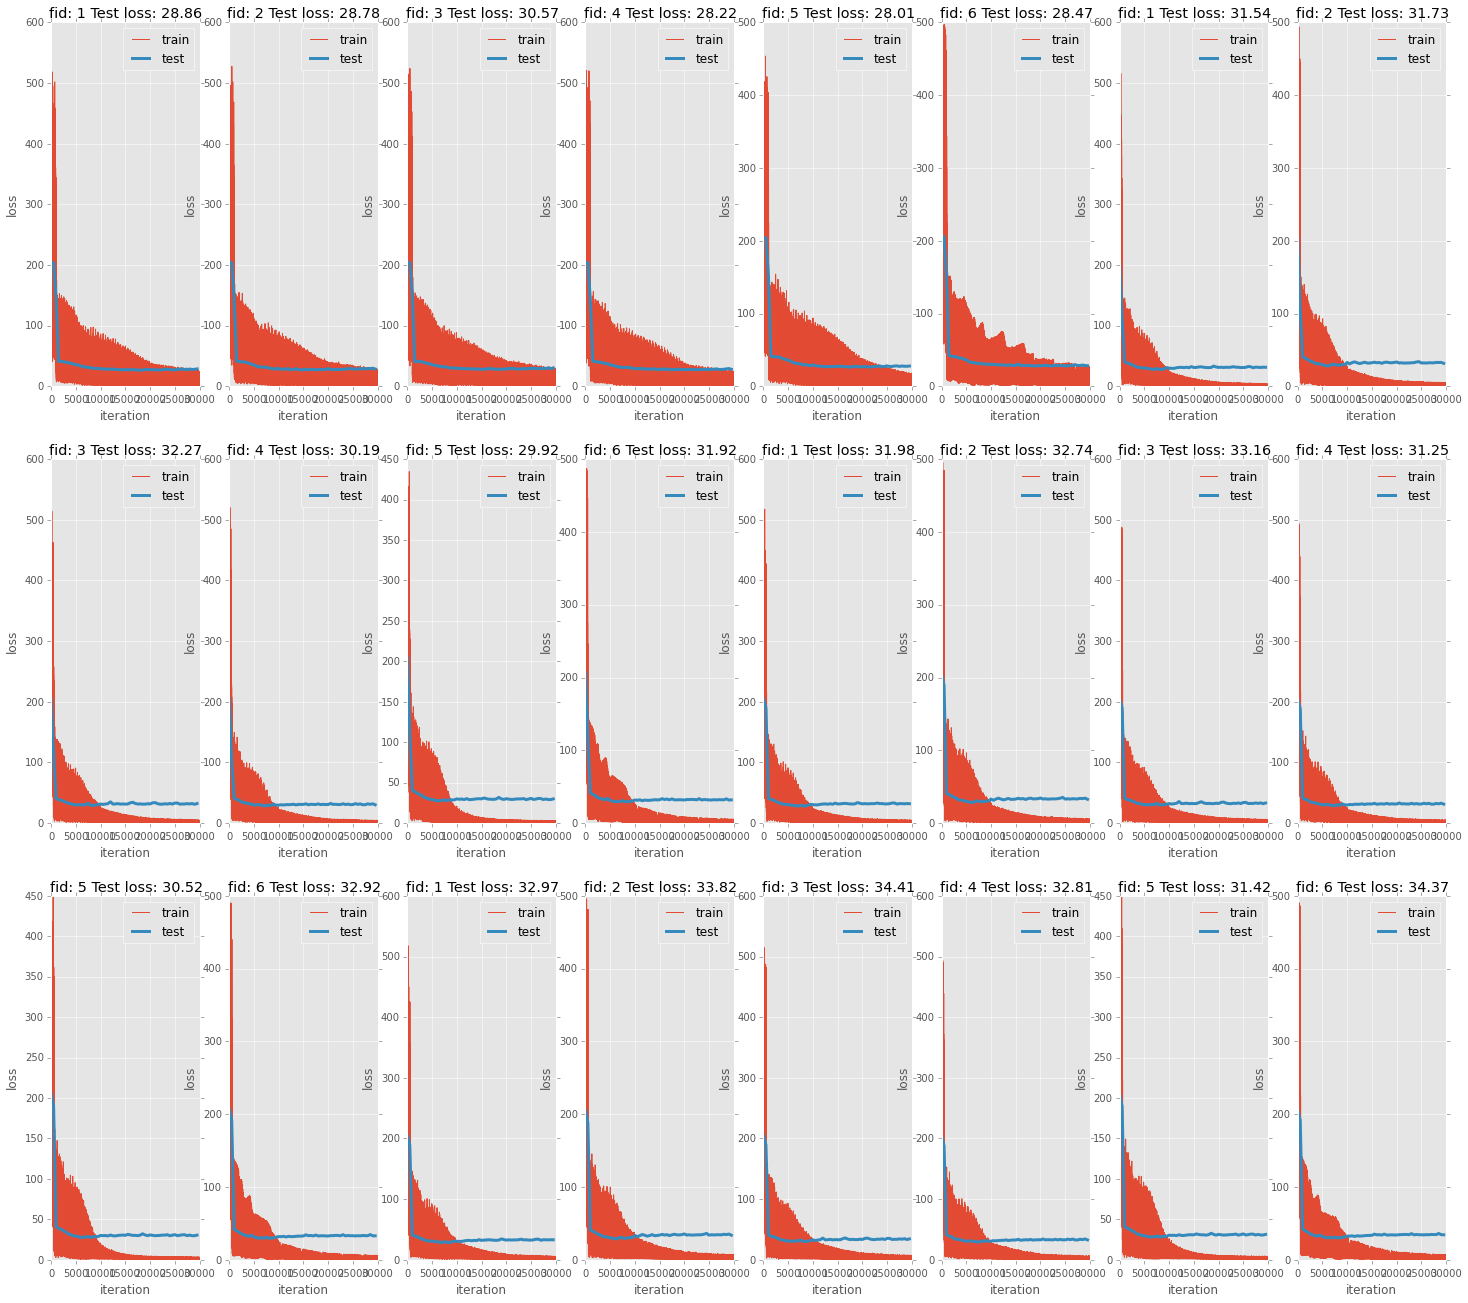

In [140]:
# plot train loss and acc
plt.rcParams['figure.figsize'] = (25, 30)
#niter = 40000
test_interval = 500
n_folds = 6
n_hype_configs = len(hype_configs.keys())
pid = 1
for hype in CV_perf_hype.keys(): 
    CV_perf = CV_perf_hype[hype]
    n_CV_configs = len(CV_perf)
    for fid in np.arange(1,n_folds+1,1):        
        train_loss = CV_perf[fid]['train_loss']
        test_loss = CV_perf[fid]['test_loss']
        ax1 = plt.subplot(n_hype_configs,n_CV_configs,pid)
        #ax2 = ax1.twinx()
        ax1.plot(arange(niter), train_loss, label='train')
        ax1.plot(test_interval * arange(len(test_loss)), test_loss, label='test', linewidth='3')
        ax1.set_xlabel('iteration')
        ax1.set_ylabel('loss')
        ax1.set_title('fid: {} Test loss: {:.2f}'.format(fid, test_loss[-1]))
        ax1.legend(loc=1)
        #ax1.set_ylim(0,100)
        pid += 1

In [144]:
#Get encodings after training
#train_filename_hdf = baseline_dir + 'data/train_CT_C688_normed.h5'
#test_filename_hdf = baseline_dir + 'data/test_CT_C688_normed.h5'
#fid=2
exp_name = 'Exp4'
#niter = 10000
modality = 'HC_CT'
preproc = 'no_preproc'
batch_size = 256
snap_interval = 2000
snap_start = 2000
#input_nodes = ['X_CT']
input_nodes = ['X_L_HC','X_R_HC','X_CT']
encoding_layer = 'output'
weight_layers = 'output'
iter_results = []
n_folds = 8
fold_euLoss = {}
fold_r = {}
cohort = 'outer_test'

for hype in hype_configs.keys():      
    node_sizes = hype_configs[hype]['node_sizes']
    dr = hype_configs[hype]['dr']
    
    for fid in np.arange(1,n_folds+1,1):
        test_filename_txt = baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)
        #test_filename_hdf = baseline_dir + 'API/data/fold{}/outer_test/{}_{}.h5'.format(fid,exp_name,preproc)
        #with open(test_filename_txt, 'w') as f:
        #        f.write(test_filename_hdf + '\n')  

        test_net_path = baseline_dir + 'API/data/fold{}/ADNI_FF_test.prototxt'.format(fid)
        with open(test_net_path, 'w') as f:
            if modality == 'HC':
                  f.write(str(adninet_ff_HC(test_filename_txt, 256, node_sizes,dr)))
            elif modality == 'CT':
                  f.write(str(adninet_ff_CT(test_filename_txt, 256, node_sizes,dr)))
            elif modality == 'HC_CT':
                  f.write(str(adninet_ff_HC_CT(test_filename_txt, 256, node_sizes,dr)))
            else:
                  print 'Wrong modality'
    
        print 'Hype # {}, Fold # {}'.format(hype, fid)
        data_path = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)
        adas_scores = load_data(data_path, 'y','no_preproc')
        net_file = baseline_dir + 'API/data/fold{}/ADNI_FF_test.prototxt'.format(fid)
        sub.call(["cp", baseline_dir + 'API/data/fold{}/{}_C688.txt'.format(fid,cohort), baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)])
        #data_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp4_ADNI1_ADAS13_NN_valid.h5'
        #adas_scores = load_data(data_path, 'Fold_{}_y'.format(fid),'no_preproc')
        iter_euLoss = []
        iter_r = []
        for snap_iter in np.arange(snap_start,niter+1,snap_interval):
            model_file = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}_iter_{}.caffemodel'.format(fid,hype,modality,snap_iter)        
            results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers)
            encodings = np.squeeze(results['X_out'])
            iter_euLoss.append(0.5*mse(encodings,adas_scores))
            iter_r.append(stats.pearsonr(encodings,adas_scores)[0])
        
        config_idx = '{}_{}'.format(hype,fid)
        fold_euLoss[config_idx] = np.array(iter_euLoss)
        fold_r[config_idx] = np.array(iter_r)

        #iter_results.append(results)

 Hype # hyp4, Fold # 1
('X_L_HC', <caffe._caffe.Blob object at 0x7f278828b1b8>)
('X_R_HC', <caffe._caffe.Blob object at 0x7f27dbeb8de8>)
Extracting features from data...
X_out.shape: (69, 1)
. ('X_L_HC', <caffe._caffe.Blob object at 0x7f277a6aade8>)
('X_R_HC', <caffe._caffe.Blob object at 0x7f27774f2938>)
Extracting features from data...
X_out.shape: (69, 1)
. ('X_L_HC', <caffe._caffe.Blob object at 0x7f278828b1b8>)
('X_R_HC', <caffe._caffe.Blob object at 0x7f27774f2938>)
Extracting features from data...
X_out.shape: (69, 1)
. ('X_L_HC', <caffe._caffe.Blob object at 0x7f277a6aade8>)
('X_R_HC', <caffe._caffe.Blob object at 0x7f27774f2938>)
Extracting features from data...
X_out.shape: (69, 1)
. ('X_L_HC', <caffe._caffe.Blob object at 0x7f278828b1b8>)
('X_R_HC', <caffe._caffe.Blob object at 0x7f27dbaa8cf8>)
Extracting features from data...
X_out.shape: (69, 1)
. ('X_L_HC', <caffe._caffe.Blob object at 0x7f277a6aade8>)
('X_R_HC', <caffe._caffe.Blob object at 0x7f27774f2938>)
Extracting fe

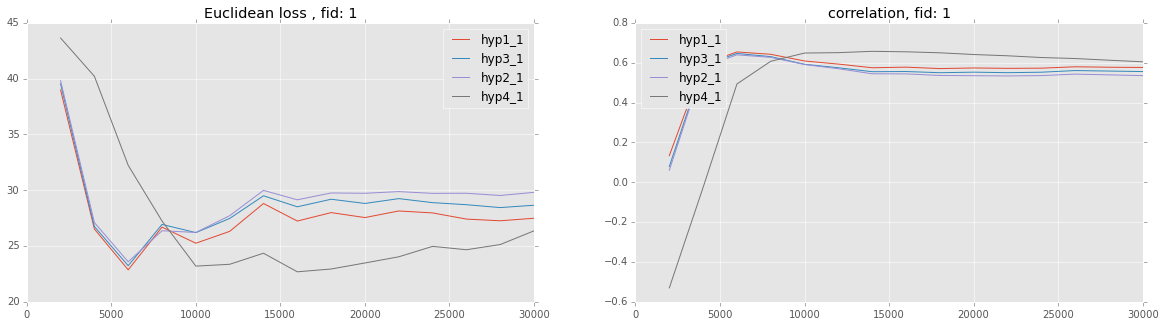

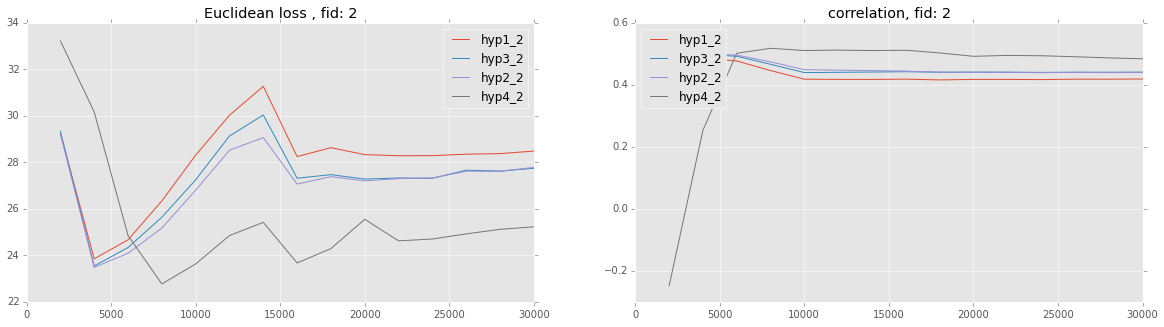

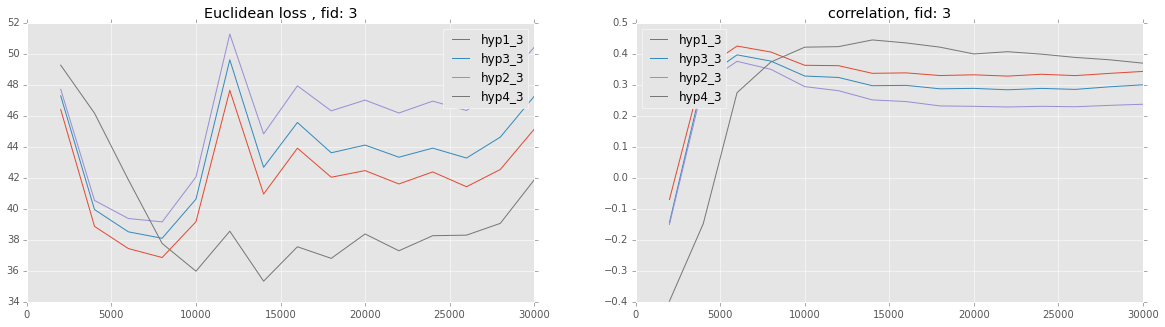

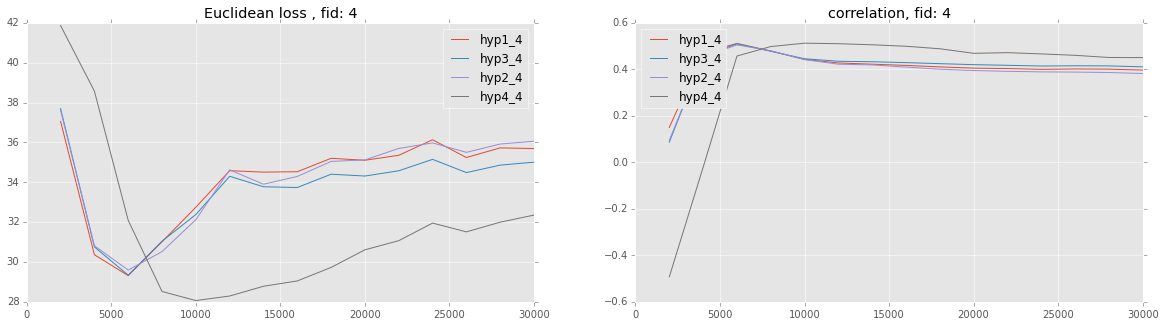

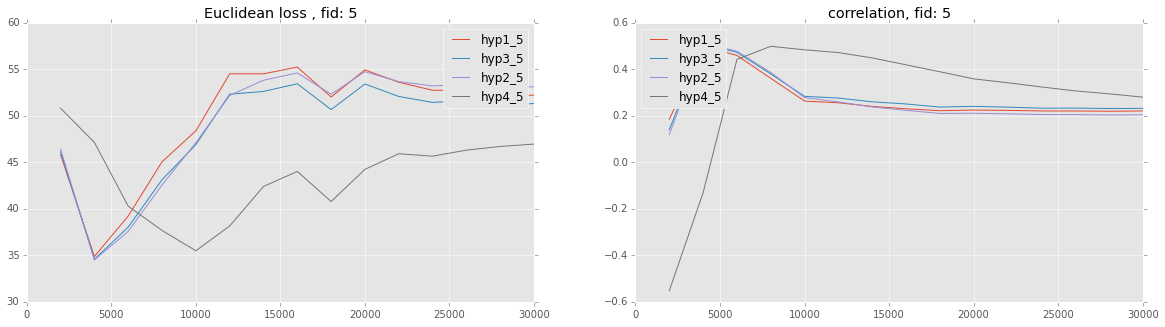

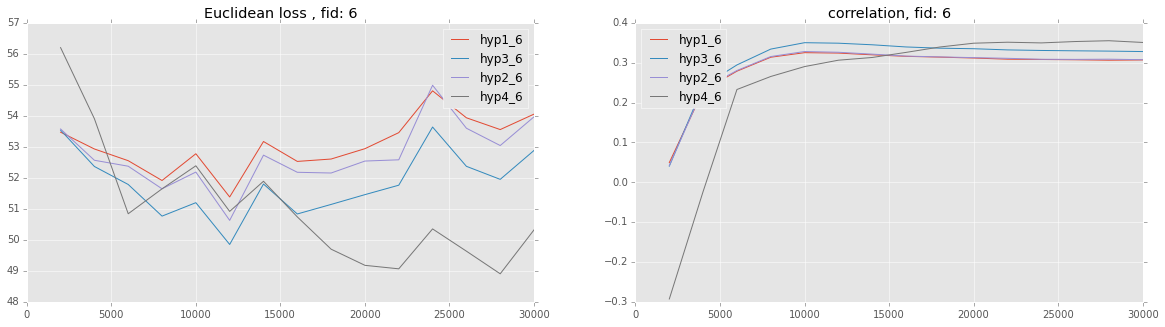

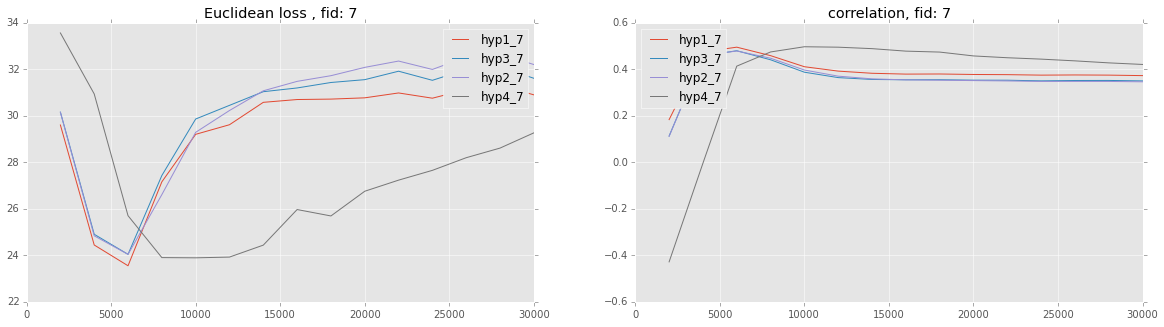

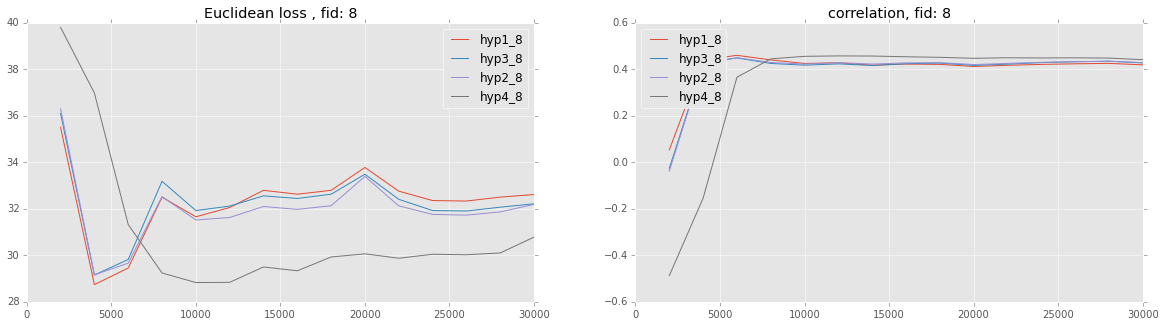

In [145]:
n_configs = len(fold_r)
plt.rcParams['figure.figsize'] = (20, 5)
n_rows = 1
n_cols = 2
pid = 1
for hype_fid in fold_euLoss.keys():
    hype = int(hype_fid.split('_')[0][3])
    fid = int(hype_fid.split('_')[1])    
    plt.figure(fid)
    plt.subplot(n_rows,n_cols,1)
    plt.plot(np.arange(snap_start,niter+1,snap_interval),fold_euLoss[hype_fid],label=hype_fid)
    plt.title('Euclidean loss , fid: {}'.format(fid))
    plt.legend()
    plt.subplot(n_rows,n_cols,2)
    plt.plot(np.arange(snap_start,niter+1,snap_interval),fold_r[hype_fid],label=hype_fid)
    plt.title('correlation, fid: {}'.format(fid))
    plt.legend(loc=2)


In [117]:
# Find optimal config based on inner_test
snap_array = np.arange(snap_start,niter+1,snap_interval)
                    
fid_hype_map = defaultdict(list)
fid_euLoss_perf= defaultdict(list)
fid_r_perf= defaultdict(list)
for hype_fid in fold_euLoss.keys():
    hype = int(hype_fid.split('_')[0][3])
    fid = int(hype_fid.split('_')[1])
    fid_euLoss_perf[fid].append(fold_euLoss[hype_fid])
    fid_r_perf[fid].append(fold_r[hype_fid])
    fid_hype_map[fid].append(hype)
    
for fid in fid_hype_map.keys():
    r_perf_array = np.array(fid_r_perf[fid])
    euLoss_perf_array = np.array(fid_euLoss_perf[fid])
    
    h,snp = np.unravel_index(euLoss_perf_array.argmin(), euLoss_perf_array.shape)
    eu_loss = euLoss_perf_array[h,snp]
    print 'fid:{}, best hype:{}, snap: {}, euLoss:{}'.format(fid, fid_hype_map[fid][h],snap_array[snp],eu_loss)
    h,snp = np.unravel_index(r_perf_array.argmax(), r_perf_array.shape)
    r = r_perf_array[h,snp]
    print 'fid:{}, best hype:{}, snap: {}, r:{}'.format(fid, fid_hype_map[fid][h],snap_array[snp],r)

fid:1, best hype:2, snap: 4000, euLoss:23.2261961351
fid:1, best hype:2, snap: 4000, r:0.64582823396
fid:2, best hype:3, snap: 2000, euLoss:23.4222083049
fid:2, best hype:3, snap: 2000, r:0.498202424271
fid:3, best hype:2, snap: 4000, euLoss:36.4320563685
fid:3, best hype:2, snap: 4000, r:0.415187013218
fid:4, best hype:2, snap: 2000, euLoss:29.853168289
fid:4, best hype:2, snap: 4000, r:0.48555687972
fid:5, best hype:3, snap: 2000, euLoss:37.193859561
fid:5, best hype:3, snap: 2000, r:0.512889662452
fid:6, best hype:4, snap: 6000, euLoss:49.5590511352
fid:6, best hype:4, snap: 8000, r:0.350478980949


In [ ]:
print stats.pearsonr(encodings,adas_scores)[0]
plt.rcParams['figure.figsize'] = (15, 10)
plt.scatter(encodings,adas_scores)

In [ ]:
print 'modality: {} mse: {}, r: {}'.format(modality, np.mean(2*np.array(fold_euLoss)[:,-1]),np.mean(np.array(fold_r)[:,-1]))
CV_perf ={'node_sizes':node_sizes,'fold_euLoss':fold_euLoss,'fold_r':fold_r}
pickleIt(CV_perf, baseline_dir + 'API/CV_perf/outer_test_{}.pkl'.format(modality))

In [ ]:
import pickle
CV_data = pickle.load(open(baseline_dir + 'API/CV_perf/outer_test_HC_CT.pkl','rb'))
print np.max(np.array(CV_data['fold_euLoss']),axis=1)
print np.max(np.array(CV_data['fold_r']),axis=1)

CV_data['node_sizes']

In [12]:
# Some defs to load data and extract encodings from trained net
import tables as tb
from sklearn import preprocessing
def load_data(data_path, input_node, preproc):
    data = tb.open_file(data_path, 'r')
    X_raw = data.get_node('/' + input_node)[:]
    if preproc == 'scale':
        X = preprocessing.scale(X_raw)
    elif preproc == 'norm_max':
        X = preprocessing.normalize(X_raw, norm='max')
    elif preproc == 'norm_l2':
        X = preprocessing.normalize(X_raw, norm='l2')
    else:
        X = X_raw
    data.close()
    return X

import collections
def extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers):
    os.chdir(os.path.dirname(net_file))
    net = caffe.Net(net_file, model_file, caffe.TEST)        
    
    print net.blobs.items()[0]
    print net.blobs.items()[1]
    
    #Get weights    
    layer_list = weight_layers
    wt_dict = collections.OrderedDict()
    for l, name in enumerate(net._layer_names):            
        if name in layer_list:
            wt_dict[name] = net.layers[l].blobs[0].data
    
    BATCH_SIZE = batch_size        
    N = load_data(data_path, input_nodes[0],'no_preproc').shape[0]
    iters = int(np.ceil(N / float(BATCH_SIZE)))

    code_layer = net.blobs[encoding_layer]
    out_shape = code_layer.data.shape    
    X_out = np.zeros(shape=(N, out_shape[1]))
    
    X_list = []
    data_layers = []
    for i, input_node in enumerate(input_nodes):
        X_list.append(load_data(data_path, input_node,'no_preproc'))
        data_layers.append(net.blobs.items()[i][1])    
        data_layers[i].reshape(BATCH_SIZE, X_list[i].shape[1]) # TODO: only works for 2-D inputs
    
    net.reshape()
        
    print 'Extracting features from data...'
    print 'X_out.shape: {}'.format(X_out.shape)
    
    for i in xrange(iters):
        print '.',
        for m, X in enumerate(X_list):
            X_b = X[i * BATCH_SIZE: (i+1) * BATCH_SIZE,:]
            batch_sampx = X_b.shape[0]
            # Pad last batch with zeros
            if X_b.shape[0] < BATCH_SIZE:
                #print 'Zero-padding last batch with {} rows'.format(BATCH_SIZE-X_b.shape[0])
                X_b = np.vstack((X_b,np.zeros((BATCH_SIZE-X_b.shape[0],X_b.shape[1]))))                       
            
            data_layers[m].data[...] = X_b
            
        net.forward()
        X_out[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer.data[0:batch_sampx,:].copy()

    return {'X_out':X_out, 'wt_dict':wt_dict}

def generate_APIdata(in_data_path,out_data_path,fid,modality,preproc):
    #Input config file generation
    in_data = load_data(in_data_path, 'Fold_{}_X_{}'.format(fid,modality), preproc)
    # get labels (no_preproc)    
    in_label = load_data(in_data_path, 'Fold_{}_y'.format(fid), 'no_preproc')

    # HDF5 is pretty efficient, but can be further compressed.
    comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
    with h5py.File(out_data_path, 'a') as f:
        if modality == 'R_CT': #Fix the typo
            modality = 'CT'
            f.create_dataset('y', data=in_label, **comp_kwargs)
            
        f.create_dataset('X_{}'.format(modality), data=in_data, **comp_kwargs)
        

In [ ]:
#Generate API style data (options: scale / normalize)
exp_name = 'Exp4'
cohorts = ['inner_train','inner_test','outer_test']
preproc = 'no_preproc'
modalities = ['L_HC','R_HC','R_CT']

for fid in np.arange(1,11,1):
    for modality in modalities:
        for cohort in cohorts:
            if cohort == 'inner_train':
                in_data_path = baseline_dir + 'caffe_input/CV_{}_ADNI1_ADAS13_NN_OuterFold_{}_train_InnerFold_1.h5'.format(exp_name,fid)
            elif cohort == 'inner_test':
                in_data_path = baseline_dir + 'caffe_input/CV_{}_ADNI1_ADAS13_NN_OuterFold_{}_valid_InnerFold_1.h5'.format(exp_name,fid)
            else:
                in_data_path = baseline_dir + 'CV_{}_ADNI1_ADAS13_NN_valid.h5'.format(exp_name)

            out_data_path = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)

            generate_APIdata(in_data_path,out_data_path,fid,modality,preproc)

In [ ]:
# Net surgery AE --> FF pretrained weights
#Review new FF net params
modality = 'HC_CT'
n_folds = 8
for fid in np.arange(1,n_folds+1,1):
    print 'fid: {}'.format(fid)
    for AE_branch in ['CT','R_HC','L_HC']:
        print 'AE_branch: {}'.format(AE_branch)

        if AE_branch == 'L_HC':
            params_FF = ['L_ff1', 'L_ff2']
            AE_iter = 10000
        elif AE_branch == 'R_HC':
            params_FF = ['R_ff1', 'R_ff2']
            AE_iter = 10000
        elif AE_branch == 'CT':
            params_FF = ['ff1', 'ff2']
            AE_iter = 50000
            #fid for pretain is 1 because it's same definition for all the folds.
            #Only use this during 1 of the modalities to avoid overwritting
            print 'Spawning new net'
            pretrain_net = caffe.Net(baseline_dir + 'API/data/fold{}/ADNI_FF_pretrain.prototxt'.format(1), caffe.TRAIN)
        else:
            print 'Wrong AE branch'

        # conv_params = {name: (weights, biases)}
        conv_params = {pr: (pretrain_net.params[pr][0].data, pretrain_net.params[pr][1].data) for pr in params_FF}

        for conv in params_FF:
            print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

        # Review AE net params 
        #fid for pretain is 1 because it's same definition for all the folds.
        net_file = baseline_dir + 'API/data/fold{}/ADNI_AE_{}_test.prototxt'.format(1,AE_branch)
        model_file = baseline_dir + 'API/data/fold{}/train_snaps/AE_snaps/AE_{}_iter_{}.caffemodel'.format(fid,AE_branch,AE_iter) 

        AE_net = caffe.Net(net_file, model_file, caffe.TEST)
        params_AE = ['encoder1', 'code']
        # fc_params = {name: (weights, biases)}
        fc_params = {pr: (AE_net.params[pr][0].data, AE_net.params[pr][1].data) for pr in params_AE}

        for fc in params_AE:
            print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

        #transplant net parameters
        for pr, pr_conv in zip(params_AE, params_FF):
            conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
            conv_params[pr_conv][1][...] = fc_params[pr][1]

        save_net = True
        if save_net:
            save_path = baseline_dir + 'API/data/fold{}/pretrained_models/adni_ff_{}_iter_{}_concat50.caffemodel'.format(fid,modality,AE_iter)
            print "Saving net to " + save_path
            pretrain_net.save(save_path)

In [ ]:
import pickle
CT_data = pickle.load(open('/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/Exp4_ADNI1_ADAS13_NN_CT_2016-03-01-11-18-48.pkl','rb'))
CT_data.keys()

In [ ]:
pred = CT_data['predicted_CV_scores'][1]
act = CT_data['actual_CV_scores'][1]
print act
print CT_data['tid_snap_config_dict']
print 'Euclidean loss: {}'.format(0.5*mse(pred,act))
print stats.pearsonr(pred,act)
plt.scatter(pred,act)